<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 44 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  object 
 1   policy_tenure                     58592 non-null  float64
 2   age_of_car                        58592 non-null  float64
 3   age_of_policyholder               58592 non-null  float64
 4   area_cluster                      58592 non-null  object 
 5   population_density                58592 non-null  int64  
 6   make                              58592 non-null  int64  
 7   segment                           58592 non-null  object 
 8   model                             58592 non-null  object 
 9   fuel_type                         58592 non-null  object 
 10  max_torque                        58592 non-null  object 
 11  max_power                         58592 non-null  object 
 12  engi

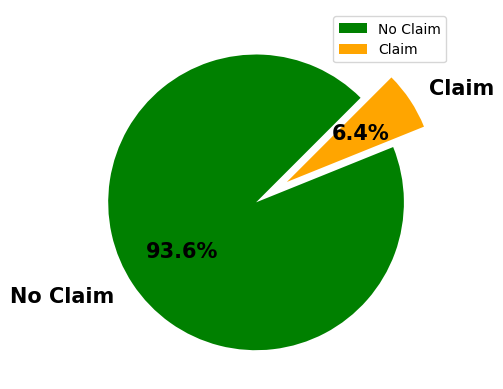

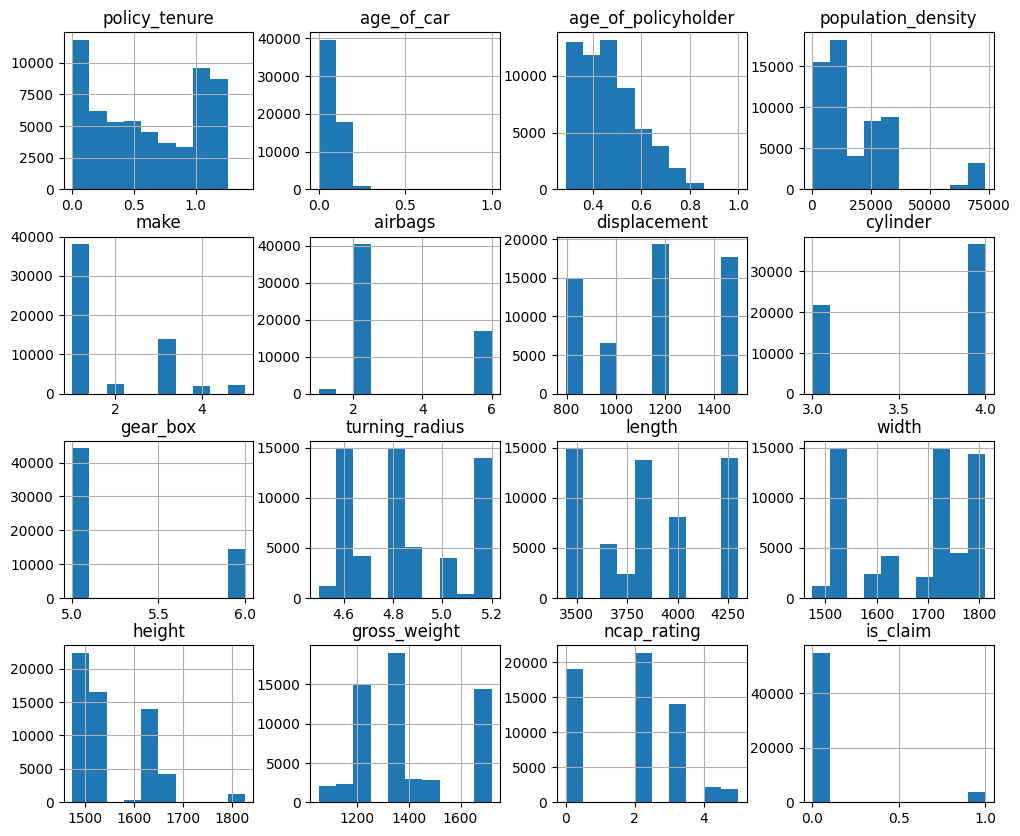

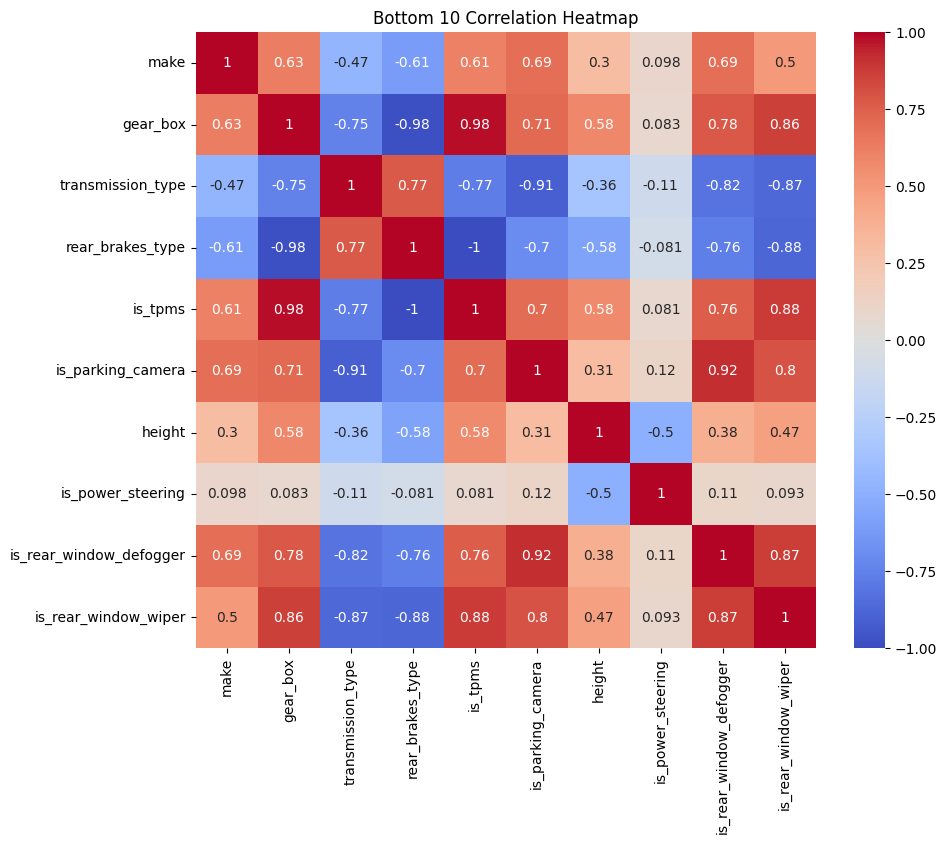

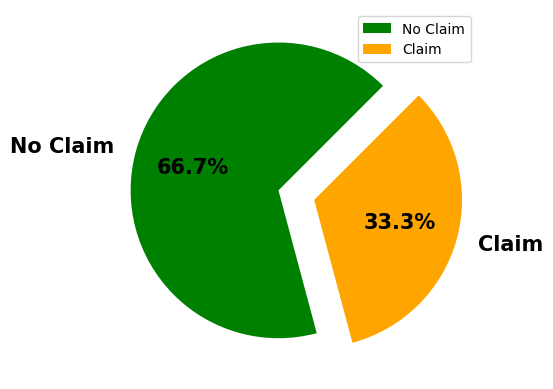

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/metrics/_classi

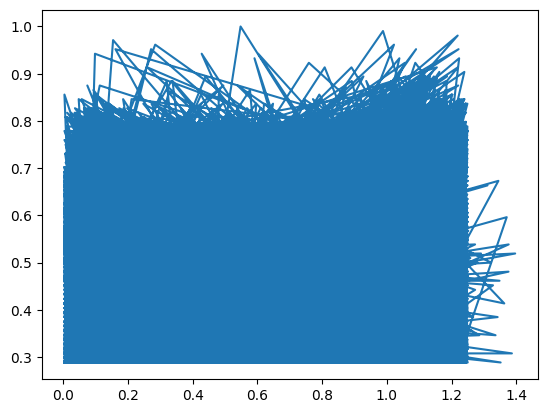

In [1]:
"""
The goal of this exercise is to implement a logistic regression
model from scikit-learn to predict if a customer will file an
insurance claim in the next 6 months. Before the model is compiled,
feature analysis will be performed to understand the structure
of the dataset.
"""

"""
1. Environment set-up
"""

# data structure libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import os
import seaborn as sns

# machine learning libraries
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report
import plotly.express as px
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

# scrap
import torch

"""
2. Read initial dataset and understand structure
"""
# read CSV and profile data
df = pd.read_csv('train.csv')

# list first 5 rows and data type of each feature
df.head(5)
df.info()

# generate pie chart to see breakdown of response vector
fig = plt.figure(facecolor='white')
plt.pie(df['is_claim'].value_counts(), labels=['No Claim', 'Claim'], radius=1, colors=['green', 'orange'],
        autopct='%1.1f%%', explode=[0.1, 0.15], labeldistance=1.15, startangle=45,
        textprops={'fontsize': 15, 'fontweight': 'bold'})
plt.legend()
plt.show()

# histogram for each variable in dataset
df.hist(figsize=(12,10))
plt.tight_layout
plt.show()

"""
2. data cleaning and preprocessing
"""
# list rows that have missing values
df.isna()
df = df.dropna(axis=0)

# drop irrelevant data types (FEATURE ENGINEERING CAN BE DONE HERE)
df = df.drop(['policy_id', 'max_torque','max_power','engine_type']
             ,axis=1)

# select columns that are categorical
categories = df.select_dtypes(include='object')

# generate dataframe of only categorical values to encode
df_category = df[categories.keys()]

# call ordinal encoder (likely not best practice here)
encoder = OrdinalEncoder()

# fit and transform categorical variables
encoder.fit(df_category)

df_category = encoder.transform(df_category)

# overwrite dataframe with new encoded values
df[categories.keys()] = df_category

# other way to do this would be to use pd.get_dummies()
"""
data_categories = df.select_dtypes(include=['object']).columns

df = pd.get_dummies(df, columns=data_categories,drop_first=True)
"""

"""
3. components and PCA
"""
# generate heat map
num_bottom_features = 10

correlation_values = df.corr()['is_claim'].abs().sort_values(ascending=True)[:num_bottom_features]

bottom_features = correlation_values.index

subset_df = df[bottom_features]

correlation_matrix = subset_df.corr()

# produce heat map
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title(f'Bottom {num_bottom_features} Correlation Heatmap')
plt.show()

# PCA to at least see what the two principal components are
pca = PCA(n_components=2)

components = pca.fit_transform(df)

fig = px.scatter(components, x=0, y=1, color=df['is_claim'])

fig.show()

# we saw earlier that the data is highly over sampled in the
# negative class, we should establish 2*positive/negative
negative_class = df[df['is_claim']==0]
positive_class = df[df['is_claim']==1]

# use resample to restructure
undersampled_majority = resample(
    negative_class,
    replace=False,
    n_samples=2*len(positive_class),
    random_state=6
)

# create data frame for analysis
df_final = pd.concat([undersampled_majority,positive_class])

# ensuring there is better parity between two classes
plt.pie(df_final['is_claim'].value_counts(), labels=['No Claim', 'Claim'], radius=1, colors=['green', 'orange'],
        autopct='%1.1f%%', explode=[0.1, 0.15], labeldistance=1.15, startangle=45,
        textprops={'fontsize': 15, 'fontweight': 'bold'})

plt.legend()
plt.show()

"""
4. fit model to data
"""
# drop is_claim from design matrix
X = df_final.drop('is_claim',axis=1)

# response vector
y_true = df_final['is_claim']

# call model
model = LogisticRegression()

# fit to data
model.fit(X, y_true)

# get vector of predictions from model
y_predict = model.predict(X)

"""
5. generate confusion matrix and a classification report
"""

# confusion matrix
matrix = confusion_matrix(y_true, y_predict)

# classification report (F1 score, accuracy etc.)
report = classification_report(y_true, y_predict)

plt.plot(df['policy_tenure'], df['age_of_policyholder'])
plt.show()

# conclusion